In [86]:
import numpy as np
import pandas as pd
import scipy.stats as scs
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Exploratory Data Analysis

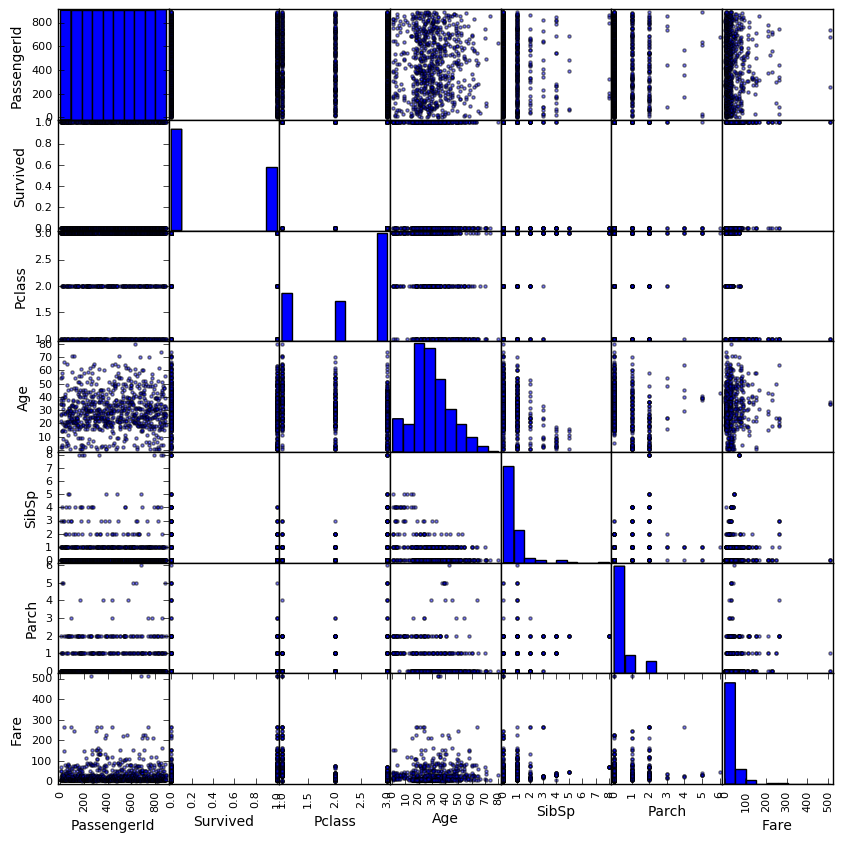

In [5]:
# Scatter_matrix
pd.scatter_matrix(df, figsize=(10, 10))
plt.show() # put this to hide lengthy output

Looks like there is no apparent relationship between any 2 variables

In [6]:
# Pop out the survived variable
# y = df['Survived']

Let's try to plot this response by several different single predictors (numeric only, except Passenger ID)

In [7]:
# Get only float columns (note that 'Survived' is no longer there)
numeric_cols = [column for column in df.columns if df[column].dtype == 'float64']
numeric_cols

['Age', 'Fare']

In [80]:
# correlation matrix
df.corr()

PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   
Sex_male        0.042939 -0.543351  0.131900  0.093254 -0.114631 -0.245489   

                 Fare  Sex_male  
PassengerId  0.012658  0.042939  
Survived     0.257307 -0.543351  
Pclass      -0.549500  0.131900  
Age          0.096067  0.093254  
SibSp        0.159651 -0.114631  
Parch        0.216225 -0.245489  
Fare         1.000000 -0.182333  
Sex_male    -0.182333  1.000000

### Age Effect

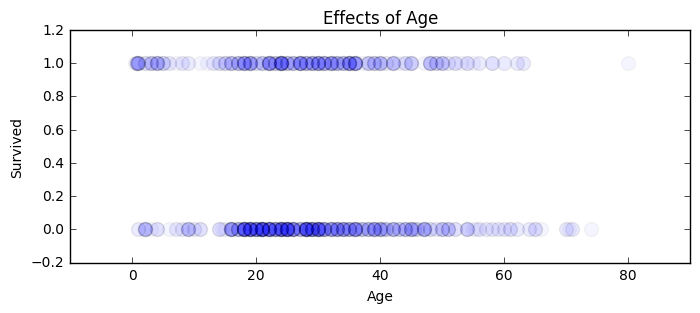

In [10]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
ax1.scatter(df['Age'], df['Survived'], alpha=0.04, s=100)
ax1.set_title('Effects of Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Survived')

From plot, we can see that there are more people 18-40 (judging by the density of alpha level). Most likely because there was a lot more young adults than children and elderly. We want to see if the survival rate in each age group is significantly different.

Divide passengers into children (0-18), young adult (18-30), adult (30-40) and elderly (50-100). Yes, at the current time, we can say a 50-year-old is old.

In [11]:
# Get rid of null age
df_all_age = df[df['Age'].notnull()]

# Statistics of age
print df_all_age['Age'].mean(), df_all_age['Age'].std()

29.6991176471 14.5264973323


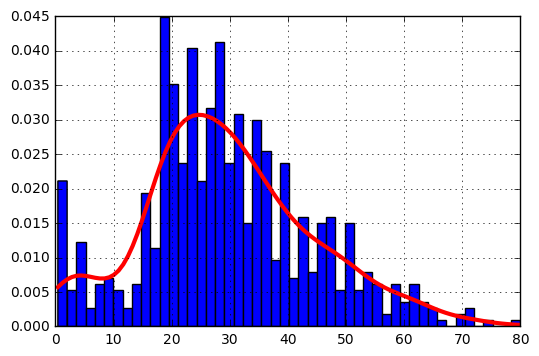

In [12]:
# Let's fit a Gaussian KDE to this data
my_pdf = scs.gaussian_kde(df_all_age['Age'])
x = np.linspace(df_all_age['Age'].min(), df_all_age['Age'].max(), 100)
# Plot histogram with KDE
df_all_age['Age'].hist(bins=50, normed=True)
plt.plot(x, my_pdf(x), linewidth=3, c='red')

In [13]:
# Create age groups
df_children = df_all_age[df_all_age['Age'] < 18]
df_young = df_all_age[(df_all_age['Age'] >= 18) & (df_all_age['Age'] <= 30)]
df_adult = df_all_age[(df_all_age['Age'] > 30) & (df_all_age['Age'] <= 50)]
df_old = df_all_age[df_all_age['Age'] > 50]

In [14]:
# Function to calculate survival rate
def survival_rate(df):
    return len(df[df['Survived'] == 1]) / float(len(df))

print survival_rate(df_children)
print survival_rate(df_young)
print survival_rate(df_adult)
print survival_rate(df_old)

print len(df_children), len(df_young), len(df_adult), len(df_old)

0.53982300885
0.35472972973
0.423236514523
0.34375
113 296 241 64


We can use ANOVA to test if the survival rates are different between groups. Also, we can regroup to make the test simpler. Since there are differences in the sizes of the groups, there should be more tests rather than eyeballing.

In [15]:
# ANOVA
scs.f_oneway(df_children['Survived'], df_young['Survived'])

F_onewayResult(statistic=11.900013841896651, pvalue=0.00061998388463530615)

Just by comparing children and young adults, we see that they are not from the same population. But how about young adults and adults?

In [16]:
scs.f_oneway(df_young['Survived'], df_adult['Survived'])

F_onewayResult(statistic=2.6349911776480548, pvalue=0.10512168291852547)

So it looks like young children and adults have higher chance of surviving. Young passengers (age 18-30) have a lower survival rate than older adults (age 30-50)

### Fare Effect

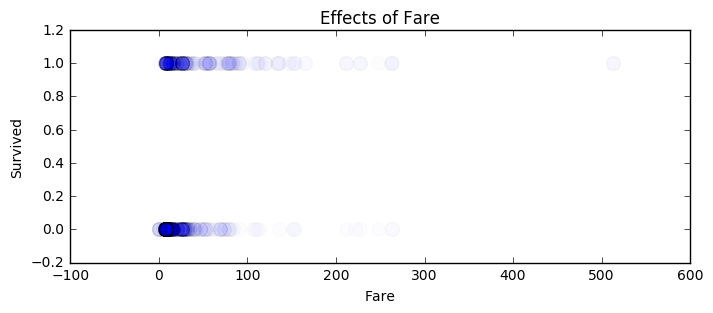

In [18]:
fig = plt.figure(figsize=(8,3))
ax2 = fig.add_subplot(111)
ax2.scatter(df['Fare'], df['Survived'], alpha=0.01, s=100)
ax2.set_title('Effects of Fare')
ax2.set_xlabel('Fare')
ax2.set_ylabel('Survived')

plt.show()

We wouldl suspect that high-class passengers will be the first to be saved. But let's test if that theory is true.

From the graph, at first there is no significance in survival rate in the fare. But there is a group of people whose fare is the highest (> 500) who survived. We will look at that in more detail.

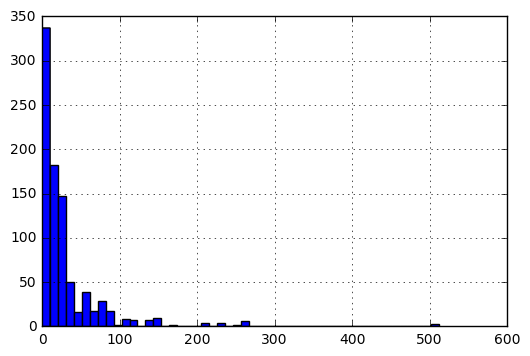

In [19]:
# Histogram of fare
df['Fare'].hist(bins=50)

In [20]:
# Median Fare
fare_med = df['Fare'].median()
print fare_med

# Mean fare
fare_mean = df['Fare'].mean()
print fare_mean

14.4542
32.2042079686


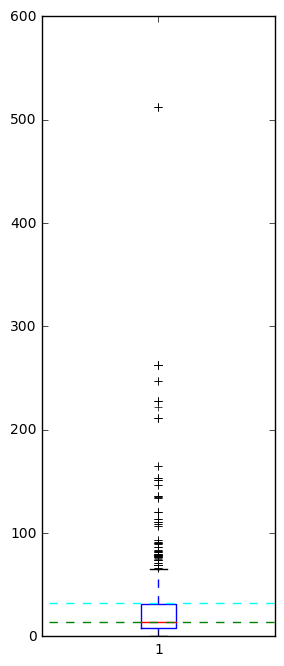

In [21]:
# Box plot fare
fig = plt.figure(figsize=(3,8))
plt.boxplot(df['Fare'])
plt.plot([0, 2], [fare_med, fare_med], '--', color="green")
plt.plot([0, 2], [fare_mean, fare_mean], '--', color="cyan")


plt.show()

In [22]:
# No null values for fare
df['Fare'].isnull().sum()

0

In [23]:
# Get the value for the fare that include the top 25% of high-class passengers
df['Fare'].quantile(q=0.75)

31.0

In [24]:
# Group passengers by high and low fare
df_high_fare = df[df['Fare'] > df['Fare'].quantile(q=0.75)]
df_low_fare = df[df['Fare'] <= df['Fare'].quantile(q=0.75)]

In [25]:
# Survival rates between these groups
print survival_rate(df_low_fare)
print survival_rate(df_high_fare)

0.318385650224
0.581081081081


Looks like our hypothesis has its ground. Let's test it.

In [26]:
# Test the hypothesis that high-class passengers have a diffence chance of surviving
scs.ttest_ind(df_low_fare['Survived'], df_high_fare['Survived'])

Ttest_indResult(statistic=-7.1644496195201226, pvalue=1.6392144803001468e-12)

Great. We have low p-value, so we reject the null hypothesis that the two groups have the same proportion of surviving. Higher-class passengers have a higher chance to survive.

### Class Effect
I think the effect of passenger class is related to that of the fare. As expected, the correlation coefficient between class and fare is a strong -0.549. So the higher fare means a low-number class.

### Gender Effect
Another hypothesis is that female passengers have a higher chance to survive than male. The correlation coefficient also show strong negative relation between male and surived.

In [27]:
# Any null value for sex? No
df['Sex'].isnull().sum()

0

In [28]:
# Dummify this variabele. Male = 1, Female = 0
df['Sex_male'] = pd.get_dummies(df['Sex'])['male']

In [29]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Sex_male  
0      0         A/5 21171   7.2500   NaN        S       1.0  
1      0          PC 17599  71.2833   C85        C       0.0  
2      0  STON/O2. 3101282   7.9250   NaN        S       0.0  
3      0            113803  53.1000  C123        S       0.0  
4      0            373450   8.0500   NaN        S       1.0

In [30]:
# Create male/female dataframes
df_male = df[df['Sex_male'] == 1]
df_female = df[df['Sex_male'] == 0]

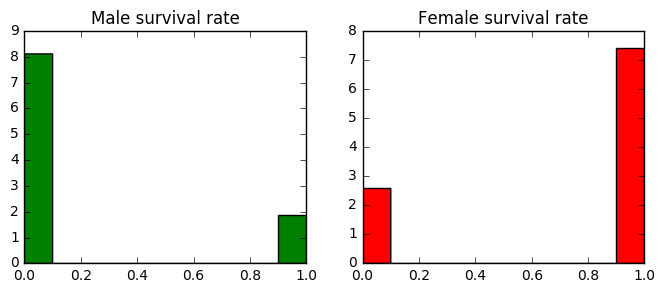

In [39]:
# Histograms of male and female survival rates
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(121)
ax1.hist(df_male['Survived'], normed=True, color='g')
ax1.set_title('Male survival rate')

ax2 = fig.add_subplot(122)
ax2.hist(df_female['Survived'], normed=True, color='r')
ax2.set_title('Female survival rate')
plt.show()

Wow! That's a big difference. Seems like female passengers truely have higher rate of surving. Let's do a hypothesis test.

In [37]:
# Hypthesis testing for proportion of survival between male and female passengers
scs.ttest_ind(df_male['Survived'], df_female['Survived'])

Ttest_indResult(statistic=-19.297816550123351, pvalue=1.4060661308802594e-69)

Just like expected, extremely smalle p-value. So we can reject the null hypothesis that the survival rates are equal.

### Embarked Effect

In [41]:
# Types of embarked
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [43]:
# How many nan embarked?
df['Embarked'].isnull().sum()

2

In [61]:
# Divide into 3 groups
df_S = df[df['Embarked'] == 'S']
df_C = df[df['Embarked'] == 'C']
df_Q = df[df['Embarked'] == 'Q']

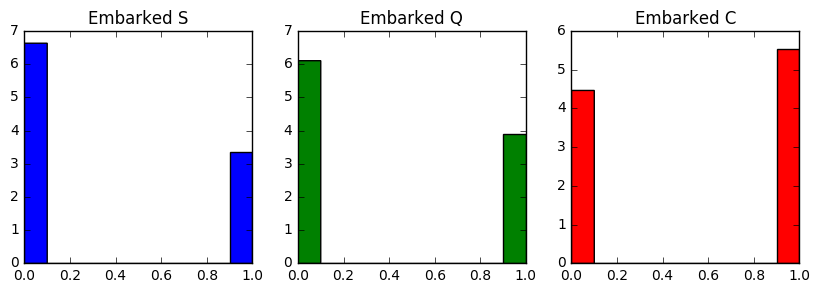

In [71]:
# Histograms
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(131)
ax1.hist(df_S['Survived'], normed=True)
ax1.set_title('Embarked S')

ax3 = fig.add_subplot(132)
ax3.hist(df_Q['Survived'], normed=True, color='g')
ax3.set_title('Embarked Q')

ax2 = fig.add_subplot(133)
ax2.hist(df_C['Survived'], normed=True, color='r')
ax2.set_title('Embarked C')

plt.show()

Embarked C has a higher survival rate by looking at the plots

In [73]:
# Testing if embarked S and Q have the same survival rate
scs.ttest_ind(df_S['Survived'], df_Q['Survived'])

Ttest_indResult(statistic=-0.91939155236853032, pvalue=0.35819914042689849)

In [75]:
# ANOVA for 3 samples
scs.f_oneway(df_S['Survived'], df_Q['Survived'], df_C['Survived'])

F_onewayResult(statistic=13.605270445693581, pvalue=1.514339014290716e-06)

The t-test shows that S and Q have similar rate of surviving. ANOVA f-test shows that 3 samples are not from the same popluation. It means embarked C doesn't have the same rate.

# Logistic Model

# Random Forest Model